<a href="https://colab.research.google.com/github/kiar24/datasci_223/blob/main/exercises/4-classification/exercise4_5assignmentTask3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify ~~all symbols~~ letters a -> g

### Subset the data

Select only the lowercase letters (a, b, ..., g) for classification

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 3. Model showdown: upper vs lowercase on abcXYZ

### Subset the data

Select out the set of upper- and lowercase (a, b, c, x, y z, A, B, C, X, Y, Z). Note that some of these classes can be confusing (e.g., x and y).

### Train and tune models

Perform a full model training and hyperparameter tuning.

1. Select candidate models, hyperparameter options, and evaluation metric
2. Set aside a validation hold-out dataset
3. Train models over K splits (use k-fold or train/test split)
    1. Split train using k-fold with the number of folds equal to the number of parameter combinations
    2. Train on k-fold split
    3. Record performance of each set of parameters
    4. Use winning set of parameters to train model on full training set
    5. Record each model's performance on that split's test set
4. Evaluate model performance and promote one model as the winner
5. Train winning model on both train + test
6. Check model performance on the validation hold-out


## 4. (_Optional_) Model comparison: classify even vs odd

**NOTE:** This is a larger dataset (~400k rows) so it will require more memory and time to train models on it.

Alternatively, you can train models on smaller subsets of the data to get a feel for which models perform better than others. Then train the winning model on the full dataset and validate against the hold-out.

### Subset the data

Select only digits and add a column for 'is_even'. Be sure to create a validation hold-out dataset for later.

### Build and compare models

Train at least two different models, compare the results and choose a winner based on an evaluation metric of your choice.

In [2]:
%pip install -q emnist pandas pyarrow numpy matplotlib seaborn scikit-learn xgboost tensorflow
%reset -f

In [3]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown

# ML packages
#Classification packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid, KFold
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28

In [4]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

In [5]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
emnist_train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
emnist_train['image'] = list(image)
emnist_train['image_flat'] = emnist_train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
emnist_train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
emnist_train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
emnist_test = pd.DataFrame()
emnist_test['image'] = list(image)
emnist_test['image_flat'] = emnist_test['image'].apply(lambda x: np.array(x).reshape(-1))
emnist_test['label'] = label
emnist_test['class'] = class_label

# Combine the training and test splits
emnist_all = pd.concat([emnist_train, emnist_test], axis=0)

# Subset for only digits 0-9
digits = emnist_all[emnist_all['label'] < 10]

# Subset for lowercase letters
lowercase = emnist_all[(emnist_all['class'] >= 'a') & (emnist_all['class'] <= 'z')]
uppercase = emnist_all[(emnist_all['class'] >= 'A') & (emnist_all['class'] <= 'Z')]

# Subset for upper- and lowercase letters a, b, c, d, e, f, g
a2g = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'd', 'e', 'f', 'g']))]

# Subset for upper- and lowercase letters a, b, c, x, y, z
abcxyz = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'A', 'B', 'C', \
                                               'x', 'y', 'z', 'X', 'Y', 'Z']))]

#Problem 1 Part 1: Subset, Cleaning, and Choosing a Model

##Subset (It's already subset as lowercase a-g in provided code a2g above)

In [8]:
#a2g is already just lower case a-g
a2g = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'd', 'e', 'f', 'g']))]
print(a2g)

#mask_true_values = (a2g[a2g['label'] == 43])
#print(mask_true_values)

# FIXME: Classify digits as even/odd
digits['is_even'] = ...

                                                    image  \
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
13      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
24      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
33      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                   ...   
116290  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116300  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116301  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116311  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116315  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               image_flat  label class  
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     36     a  
5       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     38     c  
13      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<ipython-input-8-02b0aaac0da4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  digits['is_even'] = ...


##Model Choosing and Training

In [14]:
#a2g is the subset data
#now let's pick a model
#Subset so it's small
#full data - 60,000 rows takes forever to run (45 min.). This is cut down to 6,000 just for speed to run for submission, but we did try with 60,000 as well.
a2gsmall = a2g.iloc[:6000,:]

a2gagain = a2g.iloc[:20000,:]

# 1. Select candidate models, hyperparameter options, and evaluation metric
#rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
#xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

scoring_metric = 'accuracy'
# Data splitting
X=a2gagain['image_flat'].tolist()
y=a2gagain['class'].tolist()

# If it's not liking the given labels in y, try re-encoding them:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define how many folds you want to split on
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Instantiate the Random Forest classifier
rf = RandomForestClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)




KeyboardInterrupt: 

##Testing and Confusion Matrix

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00       640
           b       1.00      1.00      1.00       339
           c       1.00      0.98      0.99       170
           d       1.00      1.00      1.00       705
           e       1.00      1.00      1.00      1701
           f       1.00      1.00      1.00       185
           g       1.00      1.00      1.00       260

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Accuracy is: 0.9985
Confusion Matrix:


array([[ 638,    0,    0,    0,    2,    0,    0],
       [   0,  339,    0,    0,    0,    0,    0],
       [   0,    0,  166,    0,    4,    0,    0],
       [   0,    0,    0,  705,    0,    0,    0],
       [   0,    0,    0,    0, 1701,    0,    0],
       [   0,    0,    0,    0,    0,  185,    0],
       [   0,    0,    0,    0,    0,    0,  260]])

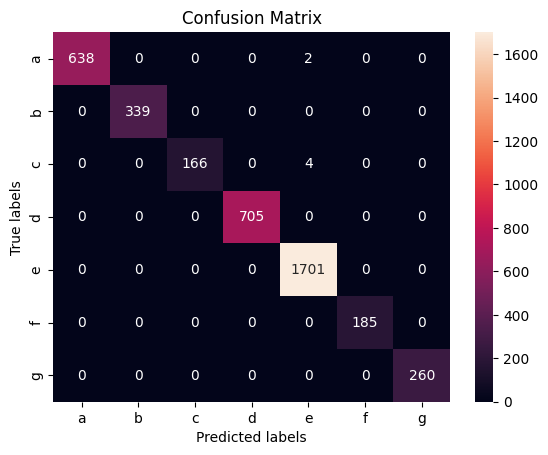

In [ ]:
# Get the best model from hyperparameter tuning - adapted from lecture
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

confusion_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']


# Evaluate the model using F1 score and confusion matrix
f1 = f1_score(y_test, y_pred, average=None)
conf_matrix = confusion_matrix(y_test, y_pred,labels=confusion_labels) # same as accuracy here for multiclass regression




ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

#labels, title and ticks - using heat map from seaborn (https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['a', 'b','c','d','e','f','g']); ax.yaxis.set_ticklabels(['a', 'b','c','d','e','f','g']);


# Print the results
print(f"Best Hyperparameters: {grid_search.best_params_}")
#print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy is: {accuracy_score(y_test,y_pred)}")
print("Confusion Matrix:")
conf_matrix


##Investigate and Improve

In [ ]:
#Model performs very well across all labels. Only e occasionally (like 6 times out of thousands) is confused: specifically with a and c but not poorly enough to have to change anything or reevalute.
#Keep in mind data was sampled to 20,000 rows out of 68795, so there may be more misclassification present but the model works very well.
#Random_state = 42 ended up being very good accuracy.




                                                    image  \
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
13      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
24      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
33      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                   ...   
116290  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116300  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116301  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116311  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116315  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               image_flat  label class  
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     36     a  
5       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     38     c  
13      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Display the size of a2g, abcxyz, digits, and the full dataset
display(Markdown(f'# Dataset Sizes'))
display(Markdown(f'**a2g**: {len(a2g)}'))
display(Markdown(f'**abcxyz**: {len(abcxyz)}'))
display(Markdown(f'**digits**: {len(digits)}'))
display(Markdown(f'**emnist_all**: {len(emnist_all)}'))

a2g = a2g.iloc[:600,:]
#print(a2g)

# Dataset Sizes

**a2g**: 68795

**abcxyz**: 65926

**digits**: 402953

**emnist_all**: 814255

#Task 3: Upper vs lowercase

In [16]:
# FIXME: Classify lettters as uppercase/lowercase

#Take the class column with label, convert to string, and pick out uppercase.
abcxyz['is_upper'] = abcxyz['class'].str.isupper()
#abcxyz['is_upper'] = abcupper
print(abcxyz)

#abcxyz['is_lower'] = abcxyz[abcxyz['class'].str.islower()]
#abcxyz['is_upper'] = abcupper


<ipython-input-16-be850fcc5d43>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcxyz['is_upper'] = abcxyz['class'].str.isupper()


                                                    image  \
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
40      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
43      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                   ...   
116283  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116284  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116287  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116290  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
116306  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               image_flat  label class  \
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     35     Z   
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     36     a   
5       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#Select Model and Train - Binary (upper or lower case)

In [17]:

#Subset so it's small
#full data - 60,000 rows takes forever to run (45 min.). This is cut down to 6,000 just for speed to run for submission, but we did try with 60,000 as well.


abcxyz_small = abcxyz.iloc[:6000,:]

# 1. Select candidate models, hyperparameter options, and evaluation metric
#rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
#xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

scoring_metric = 'accuracy'

# Data splitting
X_bin=abcxyz_small['image_flat'].tolist()
y_bin=abcxyz_small['is_upper'].tolist()


# If it's not liking the given labels in y, try re-encoding them:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

# Split data into train and validation
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)


# Define how many folds you want to split on
kf3 = KFold(n_splits=5, shuffle=True, random_state=37)

# Define the parameter grid
param_grid_bin = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Instantiate the Random Forest classifier
rf_bin = RandomForestClassifier()

# Perform grid search
grid_search_bin = GridSearchCV(estimator=rf_bin, param_grid=param_grid_bin, cv=kf3, scoring='accuracy', n_jobs=-1)
grid_search_bin.fit(X_bin, y_bin)

# Print the best parameters and best score
print("Best Parameters:", grid_search_bin.best_params_)
print("Best Score:", grid_search_bin.best_score_)




##Rough work below - logistic regression failed and didn't converge. scaling had problems so went with random forest

# Define the parameter grid - different regularization cost - https://stackoverflow.com/questions/21816346/fine-tuning-parameters-in-logistic-regression
#param_grid3 =  {'C': [0.1, 1, 10] }


# Instantiate the Random Forest classifier
#lr = LogisticRegression()

# Perform grid search
#grid_search = GridSearchCV(estimator=lr, param_grid=param_grid3, cv=5, scoring='accuracy', n_jobs=-1)
#grid_search.fit(X3, y3)

# Print the best parameters and best score
#print("Best Parameters:", grid_search.best_params_)
#print("Best Score:", grid_search.best_score_)



Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.8231666666666667


In [34]:
abcxyz['is_upper']


0          True
1         False
5         False
40         True
43        False
          ...  
116283    False
116284     True
116287    False
116290    False
116306     True
Name: is_upper, Length: 65926, dtype: bool

##Test on Upper vs lower/validation set

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200)
Validation Hold-out Score: 0.8083333333333333
[[416 171]
 [ 59 554]]
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.71      0.78       587
        True       0.76      0.90      0.83       613

    accuracy                           0.81      1200
   macro avg       0.82      0.81      0.81      1200
weighted avg       0.82      0.81      0.81      1200

Accuracy is: 0.8083333333333333
Confusion Matrix:


array([[416, 171],
       [ 59, 554]])

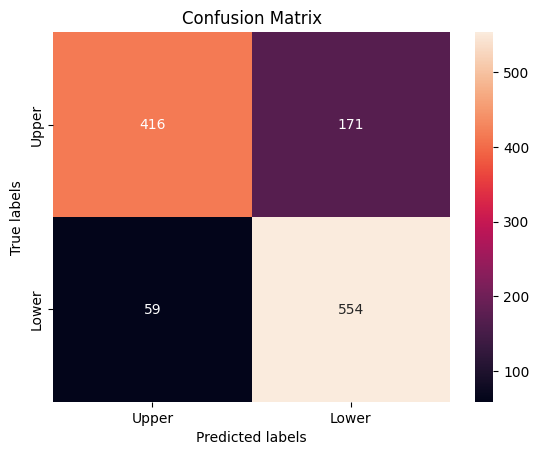

In [39]:
# Get the best model from hyperparameter tuning - adapted from lecture
best_modelbin = grid_search_bin.best_estimator_

#Train on full training set + test
print(best_modelbin.fit(X_bin_train, y_bin_train))

#Validation hold out performance
y_val_predbin = best_modelbin.predict(X_bin_test)
validation_score3 = accuracy_score(y_bin_test, y_val_predbin)
print(f"Validation Hold-out Score: {validation_score3}")

upperlower_labels_bin = ["True","False"]


# Evaluate the model using confusion matrix
conf_matrixbin = confusion_matrix(y_bin_test, y_val_predbin) # same as accuracy here for multiclass regression

print(conf_matrixbin)

ax= plt.subplot()
sns.heatmap(conf_matrixbin, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

#labels, title and ticks - using heat map from seaborn (https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(["Upper","Lower"]); ax.yaxis.set_ticklabels(["Upper","Lower"]);


# Print the results
print(f"Best Hyperparameters: {grid_search_bin.best_params_}")
#print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_bin_test, y_val_predbin))
print(f"Accuracy is: {accuracy_score(y_bin_test,y_val_predbin)}")
print("Confusion Matrix:")
conf_matrixbin

##Select Model and Train (predicting each case rather than binary)

In [7]:

#Subset so it's small
#full data - 60,000 rows takes forever to run (45 min.). This is cut down to 6,000 just for speed to run for submission, but we did try with 60,000 as well.


abcxyz_small = abcxyz.iloc[:6000,:]

# 1. Select candidate models, hyperparameter options, and evaluation metric
#rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
#xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

scoring_metric = 'accuracy'

# Data splitting
X3=abcxyz_small['image_flat'].tolist()
y3=abcxyz_small['class'].tolist()


# If it's not liking the given labels in y, try re-encoding them:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

# Split data into train and validation
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)


# Define how many folds you want to split on
kf3 = KFold(n_splits=5, shuffle=True, random_state=37)

# Define the parameter grid
param_grid3 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Instantiate the Random Forest classifier
rf3 = RandomForestClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=rf3, param_grid=param_grid3, cv=kf3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X3, y3)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)




##Rough work below - logistic regression failed and didn't converge. scaling had problems so went with random forest

# Define the parameter grid - different regularization cost - https://stackoverflow.com/questions/21816346/fine-tuning-parameters-in-logistic-regression
#param_grid3 =  {'C': [0.1, 1, 10] }


# Instantiate the Random Forest classifier
#lr = LogisticRegression()

# Perform grid search
#grid_search = GridSearchCV(estimator=lr, param_grid=param_grid3, cv=5, scoring='accuracy', n_jobs=-1)
#grid_search.fit(X3, y3)

# Print the best parameters and best score
#print("Best Parameters:", grid_search.best_params_)
#print("Best Score:", grid_search.best_score_)



Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.7948333333333334


RandomForestClassifier(max_depth=20, n_estimators=200)
Validation Hold-out Score: 0.78
[[199   0   0   0   0   1   5   5   1   0   1   0]
 [  0 101   0   0   0   0   1   1   0   0   2   0]
 [  4   0   0   0   0   0   0   1  61   0   0   0]
 [  1   1   0  30   1   1   5   0   1  23   1   1]
 [  4   3   0   0  15   0   1   1   0   1  34   0]
 [  1   2   0   0   0  51   1   1   3   1   1  19]
 [  8   0   0   0   0   0 120   0   0   0   2   0]
 [  2   2   0   0   0   0   2  68   3   0   1   0]
 [  9   0   0   0   0   1   0   0 201   0   0   0]
 [  1   0   0   8   0   0   2   0   0  47   3   0]
 [  0   2   0   0  11   0   0   1   1   0  74   0]
 [  1   0   0   0   0   8   1   3   0   0   1  30]]
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           A       0.87      0.92      0.90       130
           B       0.84      0.87      0.86        78
           C       0.74      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[199,   0,   0,   0,   0,   1,   5,   5,   1,   0,   1,   0],
       [  0, 101,   0,   0,   0,   0,   1,   1,   0,   0,   2,   0],
       [  4,   0,   0,   0,   0,   0,   0,   1,  61,   0,   0,   0],
       [  1,   1,   0,  30,   1,   1,   5,   0,   1,  23,   1,   1],
       [  4,   3,   0,   0,  15,   0,   1,   1,   0,   1,  34,   0],
       [  1,   2,   0,   0,   0,  51,   1,   1,   3,   1,   1,  19],
       [  8,   0,   0,   0,   0,   0, 120,   0,   0,   0,   2,   0],
       [  2,   2,   0,   0,   0,   0,   2,  68,   3,   0,   1,   0],
       [  9,   0,   0,   0,   0,   1,   0,   0, 201,   0,   0,   0],
       [  1,   0,   0,   8,   0,   0,   2,   0,   0,  47,   3,   0],
       [  0,   2,   0,   0,  11,   0,   0,   1,   1,   0,  74,   0],
       [  1,   0,   0,   0,   0,   8,   1,   3,   0,   0,   1,  30]])

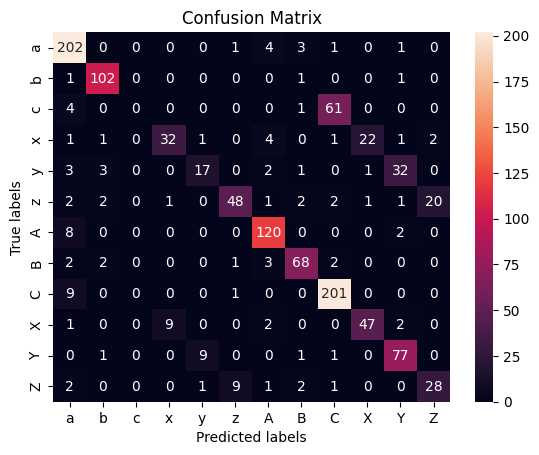

In [15]:
# Get the best model from hyperparameter tuning - adapted from lecture
best_model3 = grid_search.best_estimator_

#Train on full training set + test
print(best_model3.fit(X3_train, y3_train))

#Validation hold out performance
y_val_pred3 = best_model3.predict(X3_test)
validation_score3 = accuracy_score(y3_test, y_val_pred3)
print(f"Validation Hold-out Score: {validation_score3}")

upperlower_labels = ["a","b","c","x","y","z","A","B","C","X","Y","Z"]


# Evaluate the model using confusion matrix
conf_matrix3 = confusion_matrix(y3_test, y_val_pred3,labels=upperlower_labels) # same as accuracy here for multiclass regression



ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

#labels, title and ticks - using heat map from seaborn (https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(["a","b","c","x","y","z","A","B","C","X","Y","Z"]); ax.yaxis.set_ticklabels(["a","b","c","x","y","z","A","B","C","X","Y","Z"]);


# Print the results
print(f"Best Hyperparameters: {grid_search.best_params_}")
#print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y3_test, y_val_pred3))
print(f"Accuracy is: {accuracy_score(y3_test,y_val_pred3)}")
print("Confusion Matrix:")
conf_matrix3

##Miscellaneous Practice

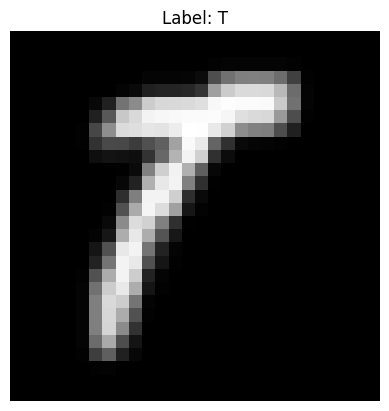

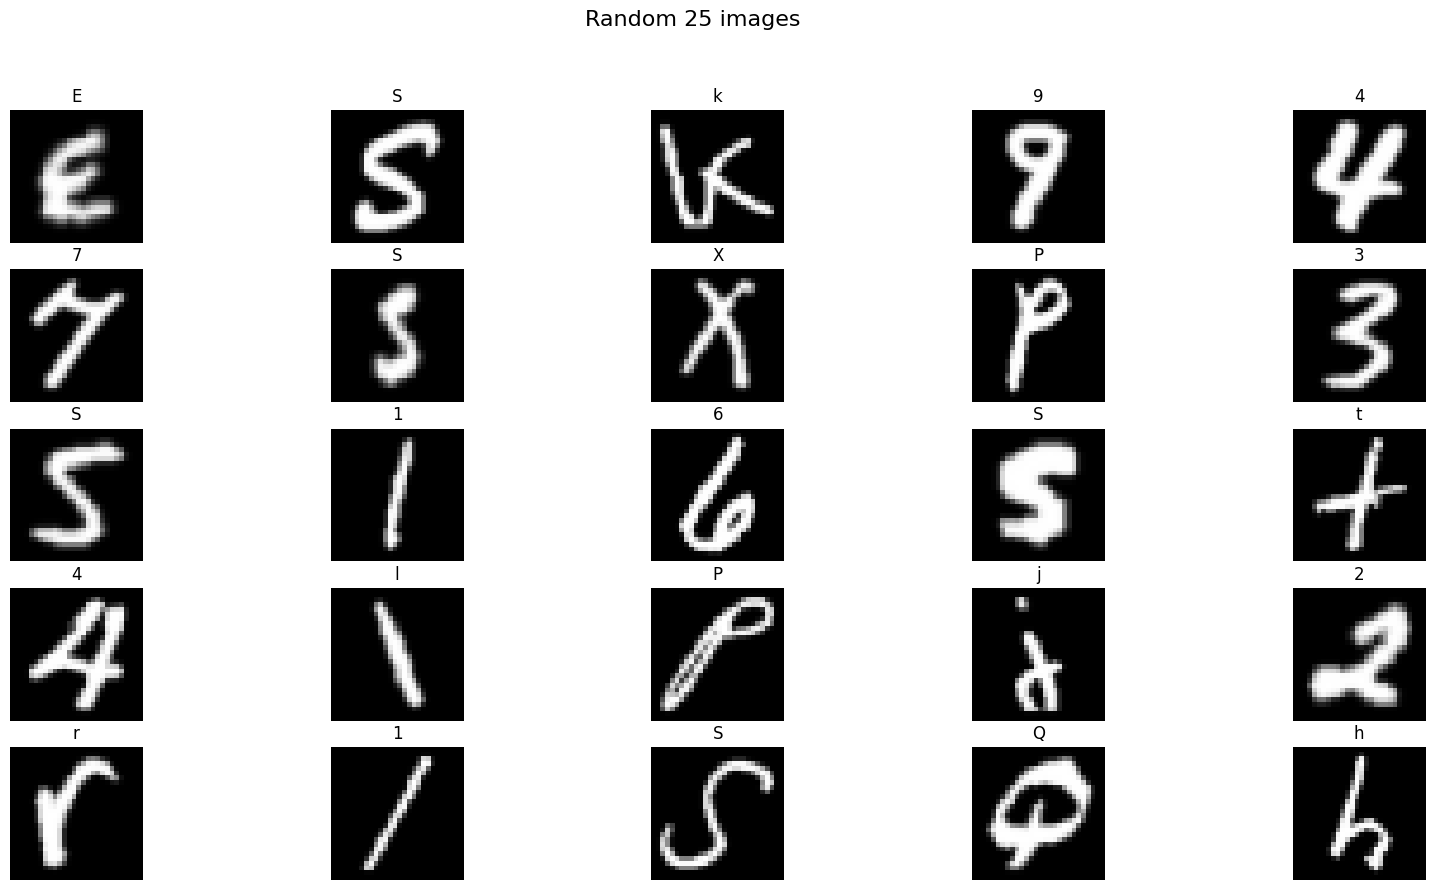

In [ ]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(emnist_train))
show_image(emnist_train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(emnist_train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
# show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?